In [18]:
import xarray as xr
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches

import functions.eddy_feedback as ef
import functions.data_wrangling as data
import functions.plotting as plot

In [2]:
data_path = Path('/home/links/ct715/data_storage/reanalysis/srip_datasets')

models = ['JRA55', 'NCEP-NCAR', 'ERA-Interim']
# models = ['JRA55']
dataset_type = ['TEM', 'ZMD']

ds = {}
for model in models:
    
    # set paths and import datasets into one set
    dataset_paths = data_path.glob(f'{model}_*_monthly_original.nc')
    dataset = xr.open_mfdataset(
        dataset_paths,
        parallel=True
    )
    
    # bespoke changes
    dataset = dataset.rename({'u': 'ubar'})

    # save to dataset dict
    ds[model] = dataset
    
era = ds['ERA-Interim']
jra = ds['JRA55']
era

<xarray.Dataset>
Dimensions:         (time: 456, pressure: 37, latitude: 121)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-14T09:00:00 ... 2016-12-14T...
  * pressure        (pressure) float32 1.0 2.0 3.0 5.0 ... 950.0 975.0 1e+03
  * latitude        (latitude) float32 -90.0 -88.5 -87.0 ... 87.0 88.5 90.0
Data variables: (12/70)
    EPF_p_qg        (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    EPF_phi_qg      (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    EPFD_p_qg       (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    EPFD_phi_qg     (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    EPF_p_pr        (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    EPF_phi_pr      (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    ...              ...
    vv_k3           (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    tt_k3           (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    uv_k3           (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    uomega_k3       (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    tomega_k3       (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
    vt_k3           (time, pressure, latitude) float32 dask.array<chunksize=(456, 37, 121), meta=np.ndarray>
Attributes:
    Title:                     Transformed Eulerian Mean (TEM) diagnostics / ...
    Description:               EP flux and other terms from the TEM equations...
    Reanalysis:                era_interim
    Project_Homepage:          http://s-rip.ees.hokudai.ac.jp/
    SPARC_Homepage:            http://www.sparc-climate.org/
    Author:                    Patrick Martineau
    Report_issues_with_data:   patrick.martineau2@mail.mcgill.ca
    Creation_Date:             17-Oct-2017 23:03:47
    history:                   Tue Oct 17 23:03:48 2017: ncra /data/A/SRIP_da...
    nco_openmp_thread_number:  1

In [3]:
# RunTimeWarning occurs during xr.corr calculation. Will be supressed. (see ChatGPT for discovery script)
ef.calculate_efp(era, data_type='reanalysis', which_div1='EPFD_phi_pr')

0.4518

In [4]:
def plot_EFP_components(ds, data_type=None, which_div1='div1_pr', hemisphere=None, TOA=10.,
                        title=''):
    
    ## DATA CHECKS
    
    # set different data types and the corresponding EP flux name
    data_type_mapping = {
        'reanalysis': which_div1,
        'reanalysis_qg': 'div1_qg',
        'pamip': None,              # handle pamip separately
        'isca': 'div1'
    }
    if data_type not in data_type_mapping:
        raise ValueError(f'Invalid data_type: {data_type}. Expected one of {list(data_type_mapping.keys())}.')
    
    # catch other pamip definition
    # Check if 'divF' or 'divFy' exists in the dataset and set which_div1
    if data_type == 'pamip':
        if 'divF' in ds.variables:
            which_div1 = 'divF'
        elif 'divFy' in ds.variables:
            which_div1 = 'divFy'
        else:
            raise ValueError("Neither 'divF' nor 'divFy' found in dataset for pamip data type.")
    else:
        which_div1 = data_type_mapping.get(data_type)
        
    ds = data.data_checker1000(ds)
        
    if hemisphere == 'NH':
        ds = data.seasonal_mean(ds, season='djf')
        ds = ds.sel(lat=slice(0,90))
    elif hemisphere == 'SH':
        ds = data.seasonal_mean(ds, season='jas')
        ds = ds.sel(lat=slice(-90,0))
    else:
        print('Hemisphere not specified.')
        
    if TOA != None:
        ds = ds.where(ds.level > 10.)
        
    #-------------------------------------------------------------------
    
    ds.ubar.mean('time').plot.contour(levels=20, yincrease=False, colors='k')
    ds[which_div1].mean('time').plot.contourf(levels=20, yincrease=False)
    
    # Plot EFP box
    rect = patches.Rectangle((25., 600.), 50, -400, fill=False, linewidth=2, color='limegreen')
    plt.gca().add_patch(rect)
    
    plt.title(title)
    
    plt.show()

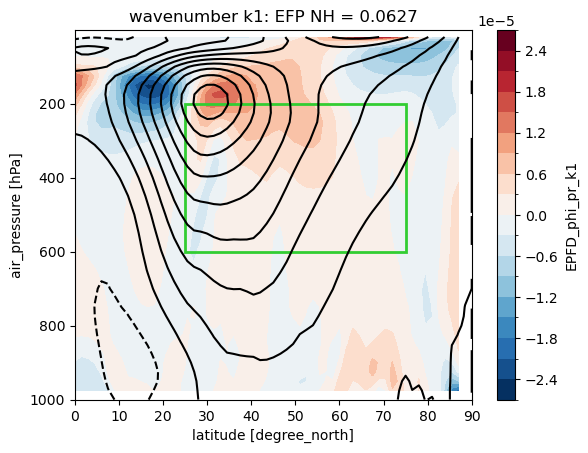

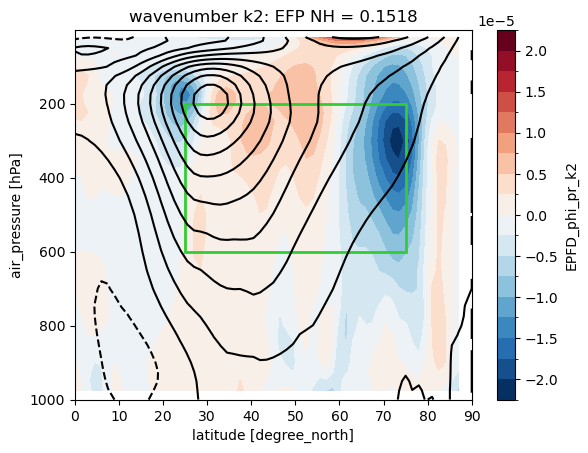

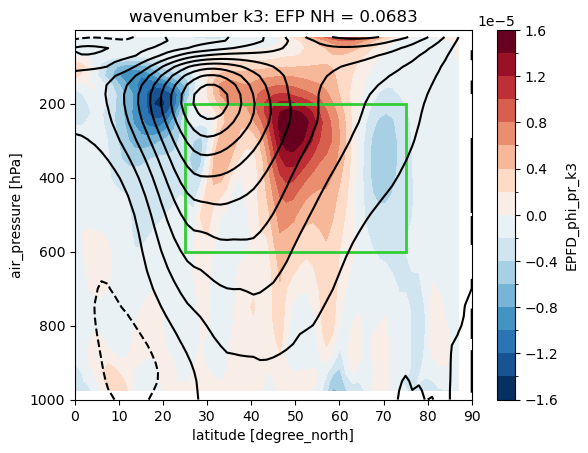

In [5]:
wavenumber = ['k1', 'k2', 'k3']

for n in wavenumber:
    efp = ef.calculate_efp(era, data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}')
    plot_EFP_components(era, data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}', hemisphere='NH', title=f'wavenumber {n}: EFP NH = {efp}')

In [6]:
era['combined_waves3'] = era.EPFD_phi_pr_k1 + era.EPFD_phi_pr_k2 + era.EPFD_phi_pr_k3
era['remaining_waves'] = era.EPFD_phi_pr - era['combined_waves3']

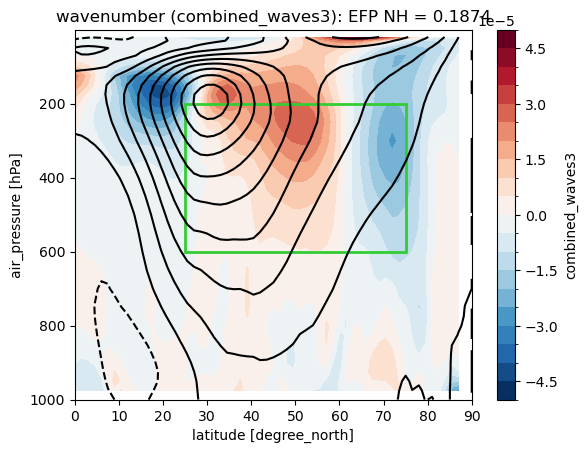

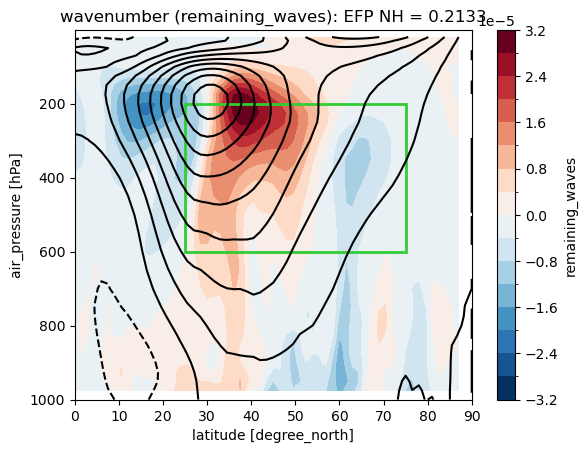

In [7]:
other_waves = ['combined_waves3', 'remaining_waves']

for item in other_waves:
    efp = ef.calculate_efp(era, data_type='reanalysis', which_div1=item)
    plot_EFP_components(era, data_type='reanalysis', which_div1=item, hemisphere='NH', title=f'wavenumber ({item}): EFP NH = {efp}')

***

# Plot correlations

In [19]:
def plot_EFP_correlation(ds, data_type, label='DJF', logscale=True, show_rect=True, hemisphere='NH',
                                top_atmos=10., cut_poles=False, figsize=(6,6),
                                title='', take_seasonal=True,
                                which_div1='div1_pr'):
    """"
    Input: DataArrays of ubar and F_\\phi
            - Dims: (time, level, lat)
                - DATASET MUST BE FULL YEAR FOR SEASONAL MEAN 
            - Subsetted to NH or SH
            - Cut off stratosphere >10. hPa
    
    Output: contourf plot matching Fig.6a in Smith et al., 2022 
    """

    ## DATA CHECKS
    
    # set different data types and the corresponding EP flux name
    data_type_mapping = {
        'reanalysis': which_div1,
        'reanalysis_qg': 'div1_qg',
        'pamip': None,              # handle pamip separately
        'isca': 'div1'
    }
    if data_type not in data_type_mapping:
        raise ValueError(f'Invalid data_type: {data_type}. Expected one of {list(data_type_mapping.keys())}.')
    
    # catch other pamip definition
    # Check if 'divF' or 'divFy' exists in the dataset and set which_div1
    if data_type == 'pamip':
        if 'divF' in ds.variables:
            which_div1 = 'divF'
        elif 'divFy' in ds.variables:
            which_div1 = 'divFy'
        else:
            raise ValueError("Neither 'divF' nor 'divFy' found in dataset for pamip data type.")
    else:
        which_div1 = data_type_mapping.get(data_type)
        
    ds = data.data_checker1000(ds)

    # choose hemisphere
    if  hemisphere == 'NH':
        ds = ds.where(ds.lat >= 0., drop=True)
        rect_box = (25., 600.)
        season='djf'
    elif  hemisphere == 'SH':
        ds = ds.where(ds.lat <= 0., drop=True)
        rect_box = (-75., 600.)
        season='jas'
    else:
        print('Hemisphere not specified')

    # separate time into annual means
    # and use .load() to force the calculation now
    if take_seasonal:
        ds = ds.sel(time=slice('1979', '2016'))
        ds = data.seasonal_mean(ds, season=season)


    # set variables
    ubar = ds.ubar
    div1 = ds[which_div1]

    # calculate correlation using built-in Xarray function
    corr = xr.corr(div1, ubar, dim='time')

    # choose top of atmosphere
    corr = corr.where(corr.level >= top_atmos, drop=True)

    if cut_poles:
        corr = corr.where(corr.lat >= -85., drop=True)
        corr = corr.where(corr.lat <= 85., drop=True)

    #------------------------------------------------------------------

    ## PLOTTING TIME

    # Initiate plot
    plt.figure(figsize=figsize)

    # actual plotting
    plt.contourf(corr.lat.values, corr.level.values, corr, cmap='RdBu_r',
                 levels=np.linspace(-0.9,0.9,19), extend='both')
    plt.colorbar(location='bottom', orientation='horizontal', shrink=0.75, label='correlation',
             extend='both', ticks=[-0.6,-0.2,0.2,0.6])

    # axis alterations
    plt.gca().invert_yaxis()
    plt.xlabel(' $(^\\circ N)$')
    if logscale:
        plt.yscale('log')
        plt.ylabel('Log pressure (hPa)')
    else:
        plt.ylabel('Pressure (hPa)')
    # plt.title('$Corr(\\bar{{u}}, {0})$ - {1}'.format(title_name, label))
    plt.title(f'{title}')

    # Plot EFP box
    if show_rect:
        rect = patches.Rectangle(rect_box, 50, -400,
                         fill=False, linewidth=2)
        plt.gca().add_patch(rect)

    plt.show()

/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


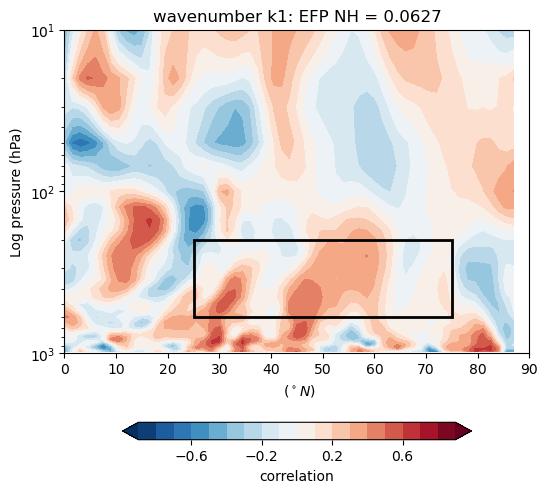

/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


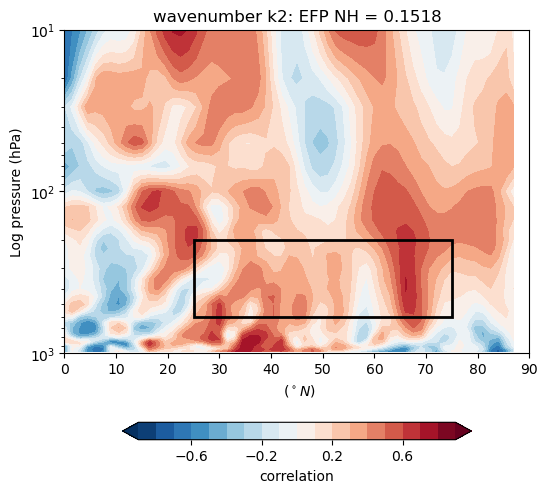

/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


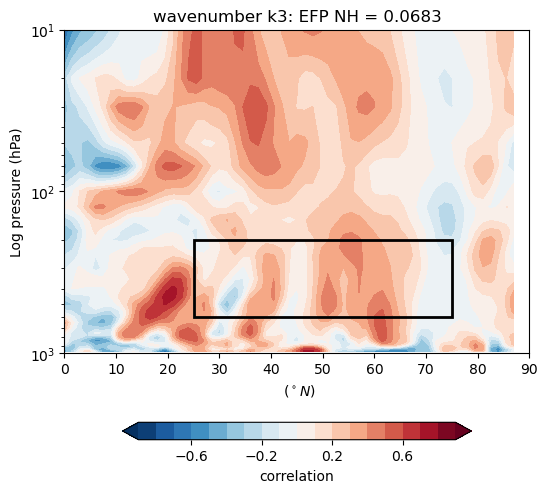

In [ ]:
for n in wavenumber:
    efp = ef.calculate_efp(era, data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}')
    plot_EFP_correlation(era, data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}', hemisphere='NH', title=f'wavenumber {n}: EFP NH = {efp}')

/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


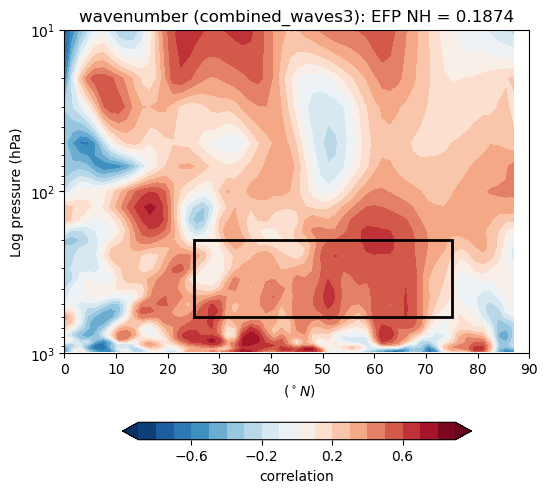

/emmy-noether/home/ct715/miniforge3/envs/eddy/lib/python3.12/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


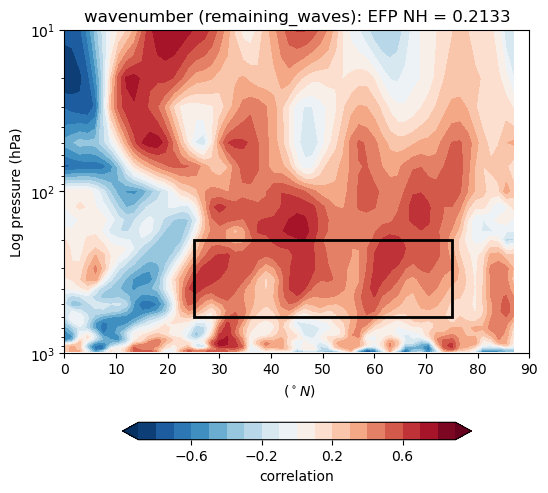

In [21]:
for item in other_waves:
    efp = ef.calculate_efp(era, data_type='reanalysis', which_div1=item)
    plot_EFP_correlation(era, data_type='reanalysis', which_div1=item, hemisphere='NH', title=f'wavenumber ({item}): EFP NH = {efp}')